# data worth and related assessments

In this notebook, we will use outputs from previous notebooks (in particular `pestpp-glm_part1.ipynb`) to undertake data worth assessments based on first-order second-moment (FOSM) techniques. "Worth" is framed here in the context of the extent to which the uncertainty surrounding a model prediction of management interest is reduced through data collection.  Given that these anayses can help target and optimize data acquisition strategies, this is a concept that really resonates with decision makers.

In [1]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size']=12
import flopy
import pyemu


In [2]:
m_d = "master_glm"

In [3]:
m = flopy.modflow.Modflow.load("freyberg.nam",model_ws=m_d,check=False,forgive=False)

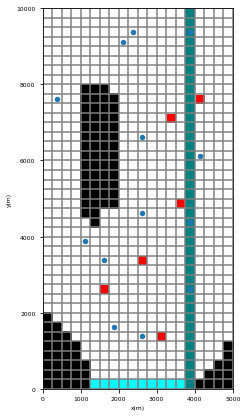

In [4]:
# plot some model attributes
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111,aspect="equal")
mm = flopy.plot.PlotMapView(model=m)
mm.plot_grid()
mm.plot_ibound()
mm.plot_bc('SFR')
mm.plot_bc("GHB")
ax = mm.ax
#m.wel.stress_period_data.plot(ax=ax,mflay=2)

# plot obs locations
obs = pd.read_csv(os.path.join("..","base_model_files","obs_loc.csv"))
                  
obs_x = [m.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [m.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.',label="water-level obs",s=80)

#plot names on the pumping well locations
wel_data = m.wel.stress_period_data[0]
wel_x = m.sr.xcentergrid[wel_data["i"],wel_data["j"]]
wel_y = m.sr.ycentergrid[wel_data["i"],wel_data["j"]]
for i,(x,y) in enumerate(zip(wel_x,wel_y)):
    ax.scatter([x],[y],color="red",marker="s",s=50)
    #ax.text(x,y,"{0}".format(i+1),ha="center",va="center")

ax.set_ylabel("y(m)")
ax.set_xlabel("x(m)")
plt.show()

In [5]:
pst = pyemu.Pst(os.path.join(m_d,"freyberg_pp.pst"))
print(pst.npar_adj)
pst.write_par_summary_table(filename="none")

569


,type,transform,count,initial value,upper bound,lower bound,standard deviation
cn_hk6,cn_hk6,log,1,0,1,-1,0.5
cn_hk7,cn_hk7,log,1,0,1,-1,0.5
cn_hk8,cn_hk8,log,1,0,1,-1,0.5
cn_prsity6,cn_prsity6,log,1,0,0.176091,-0.30103,0.11928
cn_prsity7,cn_prsity7,log,1,0,0.176091,-0.30103,0.11928
...,...,...,...,...,...,...,...
pp_vka0,pp_vka0,fixed,32,1,10,0.1,2.475
pp_vka1,pp_vka1,log,32,0,1,-1,0.5
pp_vka2,pp_vka2,fixed,32,1,10,0.1,2.475
welflux,welflux,log,25,0,1,-1,0.5


first ingredient: parameter covariance matrix (representing prior uncertainty in this instance)

In [6]:
cov = pyemu.Cov.from_binary(os.path.join(m_d,"prior_cov.jcb")).to_dataframe()
cov = cov.loc[pst.adj_par_names,pst.adj_par_names]
cov = pyemu.Cov.from_dataframe(cov)

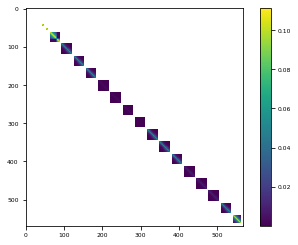

In [7]:
# let's inspect only
x = cov.x.copy()
x[x<1e-7] = np.nan
c = plt.imshow(x)
plt.colorbar()

In [8]:
pst.adj_par_groups

['cn_hk6',
 'cn_hk7',
 'cn_hk8',
 'cn_prsity6',
 'cn_prsity7',
 'cn_prsity8',
 'cn_rech10',
 'cn_rech11',
 'cn_rech12',
 'cn_rech13',
 'cn_rech14',
 'cn_rech15',
 'cn_rech16',
 'cn_rech17',
 'cn_rech18',
 'cn_rech19',
 'cn_rech20',
 'cn_rech21',
 'cn_rech22',
 'cn_rech23',
 'cn_rech24',
 'cn_rech25',
 'cn_rech26',
 'cn_rech2',
 'cn_rech3',
 'cn_rech4',
 'cn_rech5',
 'cn_rech6',
 'cn_rech7',
 'cn_rech8',
 'cn_rech9',
 'cn_ss6',
 'cn_ss7',
 'cn_ss8',
 'cn_sy6',
 'cn_sy7',
 'cn_sy8',
 'cn_vka6',
 'cn_vka7',
 'cn_vka8',
 'ghbcond_k00',
 'ghbcond_k01',
 'ghbcond_k02',
 'pp_hk0',
 'pp_hk1',
 'pp_hk2',
 'pp_prsity0',
 'pp_prsity1',
 'pp_prsity2',
 'pp_rech0',
 'pp_ss0',
 'pp_ss1',
 'pp_ss2',
 'pp_sy0',
 'pp_sy1',
 'pp_sy2',
 'pp_vka1',
 'welflux',
 'welflux_k02']

second ingredient: jacobian matrix

In [9]:
jco = os.path.join(m_d,"freyberg_pp.jcb")

the third ingredient--the (diagonal) noise covariance matrix--populated on-the-fly using weights when constructing the Schur object below...

In [10]:
sc = pyemu.Schur(jco=jco,parcov=cov)

In [11]:
sc

In [12]:
sc.get_forecast_summary()

,prior_var,post_var,percent_reduction
fa_hw_20171001,789307.869122,17890.018498,97.733455
fa_tw_20171001,866637.712056,14650.290571,98.309525
hds_00_013_002_021,0.515632,0.016193,96.859506
part_time,31590.085323,7014.140502,77.796386
part_status,0.000000,0.000000,NaN


So that was easy...but maybe not the standard use case.  In many modeling analyses, there will be a separate scenario model - it is this model that will yield the forecast sensitivity vector(s) needed to map parameter uncertainty to forecast uncertainty.  That is, you will need to run the scenario model once for each parameter to fill a separate jacobian -  jacobian that has the same columns as the obervation jacobian, but has rows that are the forecasts.  

Now we didnt do that here, but we can "fake" it but extracting the forecast rows from the full jacobian and "pretending" it is scenario-based forecast jacobian.

In [13]:
obs_jco = pyemu.Jco.from_binary(jco)
obs_jco.shape

(7272, 569)

In [14]:
forecast_jco = obs_jco.get(row_names=pst.forecast_names,drop=True)

In [15]:
forecast_jco.shape,obs_jco.shape

((5, 569), (7267, 569))

In [16]:
sc = pyemu.Schur(pst=pst,jco=obs_jco,forecasts=forecast_jco.T,parcov=cov)

In [17]:
sc.get_forecast_summary()

,prior_var,post_var,percent_reduction
fa_hw_20171001,789307.869122,17890.018498,97.733455
fa_tw_20171001,866637.712056,14650.290571,98.309525
hds_00_013_002_021,0.515632,0.016193,96.859506
part_time,31590.085323,7014.140502,77.796386
part_status,0.000000,0.000000,NaN


There you go...easy peasy.  What do these results imply about the "value" of proceeding with history matching?  Are we justified to continue???

### there we have it--all computations done and contained within `sc`.  We will only be required to access different parts of `sc` below...

### Parameter uncertainty

First let's inspect the (approx) posterior parameter covariance matrix and the reduction in parameter uncertainty through "data assimilation", before mapping to forecasts... (note that this matrix is ${\it not}$ forecast-specific)

In [18]:
sc.posterior_parameter.to_dataframe().sort_index(axis=1).iloc[100:105:,100:105]

,hk0_10,hk0_11,hk0_12,hk0_13,hk0_14
hk0_10,0.111082,0.004682,0.026984,0.040851,0.002999
hk0_11,0.004682,0.111083,0.015011,0.005512,0.040848
hk0_12,0.026984,0.015011,0.111078,0.040848,0.011850
hk0_13,0.040851,0.005512,0.040848,0.111086,0.004683
hk0_14,0.002999,0.040848,0.011850,0.004683,0.111082


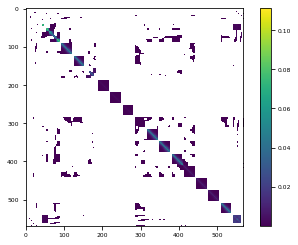

In [19]:
x = sc.posterior_parameter.x.copy()
x[x<1e-7] = np.nan
c = plt.imshow(x)
plt.colorbar(c)

We can see the posterior variance for each parameter along the diagonal. The off-diags are symmetric. a work of art!

In [20]:
par_sum = sc.get_parameter_summary().sort_values("percent_reduction",ascending=False)
par_sum

,prior_var,post_var,percent_reduction
const_sy6__cn,0.111111,0.008185,9.263315e+01
const_hk8__cn,0.111111,0.016112,8.549931e+01
welflux_000,0.111111,0.024307,7.812401e+01
welflux_009,0.111111,0.030661,7.240477e+01
welflux_021,0.111111,0.031297,7.183304e+01
...,...,...,...
sy1_23,0.019839,0.019839,-4.440892e-14
sy2_27,0.019839,0.019839,-4.440892e-14
sy2_00,0.019839,0.019839,-4.440892e-14
sy2_28,0.019839,0.019839,-4.440892e-14


<AxesSubplot:>

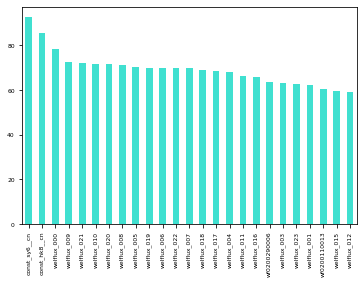

In [21]:
par_sum.loc[par_sum.index[:25],"percent_reduction"].plot(kind="bar",color="turquoise")

What have we achieved by "notionally calibrating" our model to water levels and fluxes? Which parameters are informed? Will they matter for the forecast of interest? Which ones are un-informed?

In [22]:
pst.nnz_obs_groups

['fo_gage_1',
 'trgw_002_015',
 'trgw_002_009',
 'trgw_003_008',
 'trgw_009_001',
 'trgw_013_010',
 'trgw_015_016',
 'trgw_021_010',
 'trgw_022_015',
 'trgw_024_004',
 'trgw_026_006',
 'trgw_029_015',
 'trgw_033_007',
 'trgw_034_010']

## Forecast uncertainty

In [23]:
forecasts = sc.pst.forecast_names
forecasts

['fa_hw_20171001',
 'fa_tw_20171001',
 'hds_00_013_002_021',
 'part_time',
 'part_status']

In [24]:
df = sc.get_forecast_summary()
df

,prior_var,post_var,percent_reduction
fa_hw_20171001,789307.869122,17890.018498,97.733455
fa_tw_20171001,866637.712056,14650.290571,98.309525
hds_00_013_002_021,0.515632,0.016193,96.859506
part_time,31590.085323,7014.140502,77.796386
part_status,0.000000,0.000000,NaN


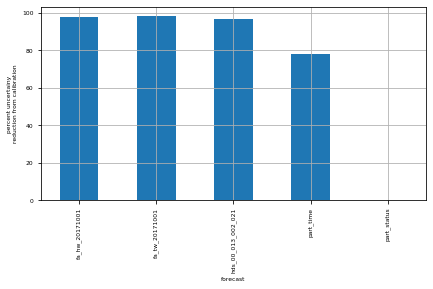

In [25]:
# make a pretty plot 
fig = plt.figure()
ax = plt.subplot(111)
ax = df["percent_reduction"].plot(kind='bar',ax=ax,grid=True)
ax.set_ylabel("percent uncertainy\nreduction from calibration")
ax.set_xlabel("forecast")
plt.tight_layout()

Surprise, surprise... Some forecasts benefit from calibration, some do not! 

### Before moving onto data worth, let's look at the contribution of different parameters to forecast uncertainty

Parameter contributions to uncertainty are quantified by "fixing" parameters (or parameter groups) and observing the uncertainty reduction as a result. This approach is of course subject to some sizable assumptions--related to parameter representativeness. But it can be very informative. Let's do by group.

In [26]:
par_contrib = sc.get_par_group_contribution()

In [27]:
par_contrib.head()

,fa_hw_20171001,fa_tw_20171001,hds_00_013_002_021,part_time,part_status
base,17890.018498,14650.290571,0.016193,7014.140502,0.0
cn_hk6,17890.015465,14649.382465,0.016193,7013.902386,0.0
cn_hk7,17890.014300,14650.285175,0.016193,7014.138291,0.0
cn_hk8,17723.961197,14302.706256,0.016093,6983.638084,0.0
cn_prsity6,17890.018498,14650.290571,0.016193,7003.335963,0.0


In [28]:
base = par_contrib.loc["base",:]
par_contrib = 100.0 * (base - par_contrib) / base
par_contrib.sort_index()

,fa_hw_20171001,fa_tw_20171001,hds_00_013_002_021,part_time,part_status
base,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN
cn_hk6,1.695016e-05,6.198555e-03,1.582819e-03,3.394802e-03,NaN
cn_hk7,2.346177e-05,3.683642e-05,3.168971e-04,3.153197e-05,NaN
cn_hk8,9.282120e-01,2.372542e+00,6.211559e-01,4.348704e-01,NaN
cn_prsity6,4.067049e-14,1.365767e-13,2.142507e-14,1.540394e-01,NaN
cn_prsity7,4.067049e-14,1.365767e-13,2.142507e-14,2.217111e-01,NaN
cn_prsity8,4.067049e-14,1.365767e-13,2.142507e-14,2.837265e+01,NaN
cn_rech10,2.741618e-09,2.360665e-04,9.282007e-03,4.072063e-03,NaN
cn_rech11,4.934082e-06,5.372041e-04,1.157069e-02,7.197790e-03,NaN
cn_rech12,5.034532e-07,1.983298e-03,1.701906e-02,1.330320e-02,NaN


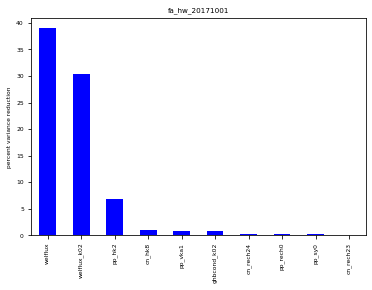

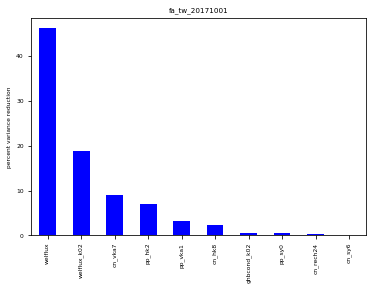

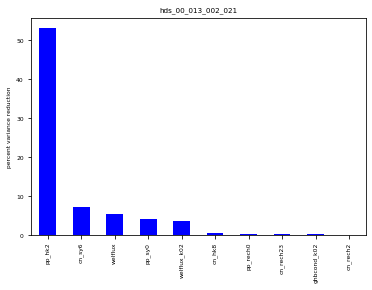

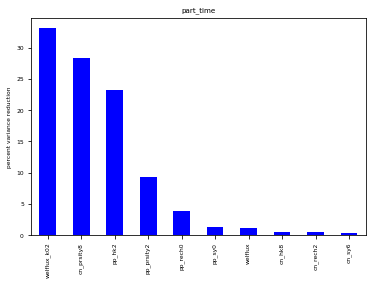

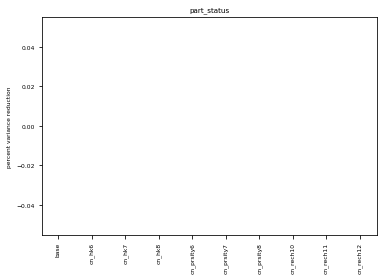

In [29]:
for forecast in par_contrib.columns:
    fore_df = par_contrib.loc[:,forecast].copy()
    fore_df.sort_values(inplace=True, ascending=False)
    ax = fore_df.iloc[:10].plot(kind="bar",color="b")
    ax.set_title(forecast)
    ax.set_ylabel("percent variance reduction")
    plt.show()

### Data worth

### what is the worth of ${\it existing}$ observations?

What is happening under the hood is that we are recalculating the Schur complement without some of the observations to see how the posterior forecast uncertainty increases (wrt a "base" condition in which we have all observation data available).

In [30]:
sc.pst.nnz_obs_groups

['fo_gage_1',
 'trgw_002_015',
 'trgw_002_009',
 'trgw_003_008',
 'trgw_009_001',
 'trgw_013_010',
 'trgw_015_016',
 'trgw_021_010',
 'trgw_022_015',
 'trgw_024_004',
 'trgw_026_006',
 'trgw_029_015',
 'trgw_033_007',
 'trgw_034_010']

In [31]:
sc.get_obs_group_dict().keys()

dict_keys(['flaqx', 'fo_gage_1', 'fo_hw', 'fo_tw', 'hds', 'obgnme', 'trgw_002_009', 'trgw_002_015', 'trgw_003_008', 'trgw_009_001', 'trgw_013_010', 'trgw_015_016', 'trgw_021_010', 'trgw_022_015', 'trgw_024_004', 'trgw_026_006', 'trgw_029_015', 'trgw_033_007', 'trgw_034_010'])

In [32]:
dw_rm = sc.get_removed_obs_group_importance()
dw_rm

,fa_hw_20171001,fa_tw_20171001,hds_00_013_002_021,part_time,part_status
base,17890.018498,14650.290571,0.016193,7014.140502,0.0
flaqx,17890.018498,14650.290571,0.016193,7014.140502,0.0
fo_gage_1,21847.666356,17229.098765,0.016646,7114.766694,0.0
fo_hw,17890.018498,14650.290571,0.016193,7014.140502,0.0
fo_tw,17890.018498,14650.290571,0.016193,7014.140502,0.0
hds,17890.018498,14650.290571,0.016193,7014.140502,0.0
obgnme,17890.018498,14650.290571,0.016193,7014.140502,0.0
trgw_002_009,18053.484194,14690.209789,0.016324,7113.858170,0.0
trgw_002_015,19724.698411,14770.421611,0.016239,7015.069852,0.0
trgw_003_008,18095.535493,14694.280981,0.016316,7134.239753,0.0


Here the ``base`` row contains the results of the Schur complement calculation (in terms of forecast uncertainty variance) using all observations.  

In [33]:
# let's normalize to make more meaningful comparisons of data worth (unctainty variance reduction)
base = dw_rm.loc["base",:]
dw_rm = 100 * (dw_rm  - base) / base
dw_rm.head()

,fa_hw_20171001,fa_tw_20171001,hds_00_013_002_021,part_time,part_status
base,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,NaN
flaqx,0.0000,-7.449638e-14,-4.285015e-14,-6.483294e-14,NaN
fo_gage_1,22.1221,1.760244e+01,2.795942e+00,1.434619e+00,NaN
fo_hw,0.0000,-7.449638e-14,-4.285015e-14,-6.483294e-14,NaN
fo_tw,0.0000,-7.449638e-14,-4.285015e-14,-6.483294e-14,NaN


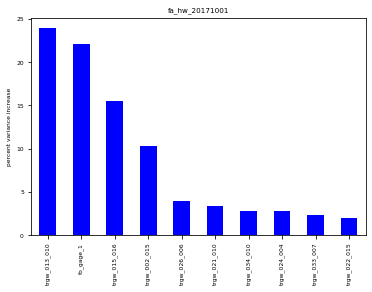

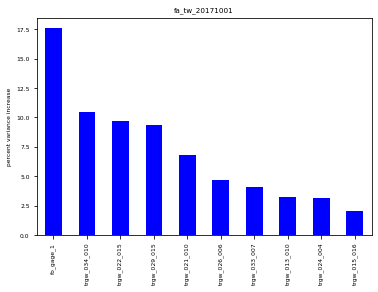

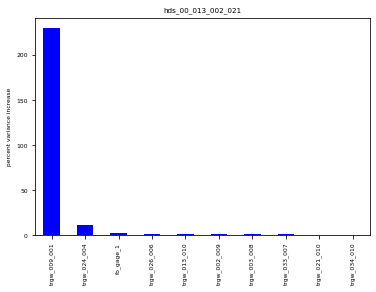

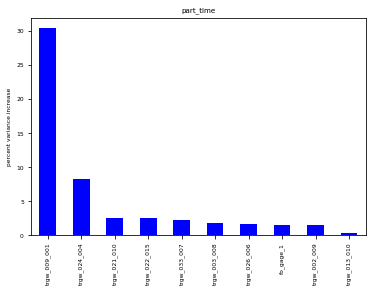

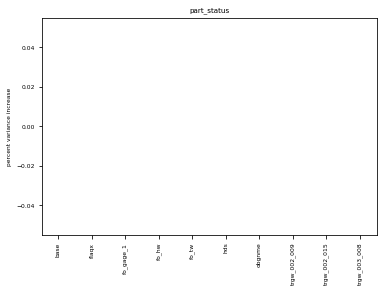

In [34]:
for forecast in dw_rm.columns:
    fore_df = dw_rm.loc[:,forecast].copy()
    fore_df.sort_values(inplace=True, ascending=False)
    ax = fore_df.iloc[:10].plot(kind="bar",color="b")
    ax.set_title(forecast)
    ax.set_ylabel("percent variance increase")
    plt.show()

There is also an option to calculate the worth of observations by taking a "base" condition of zero observation (i.e., a priori) and calculating the reduction in uncertainty through adding observations to the dataset. 

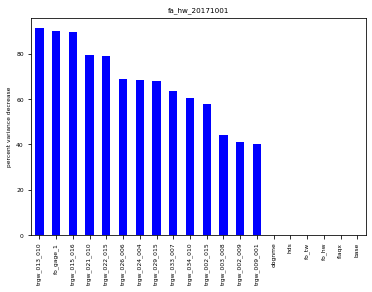

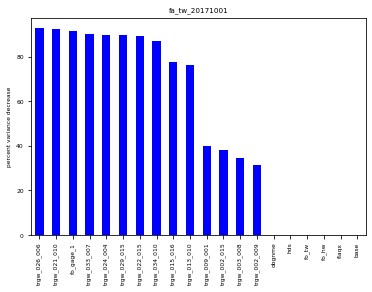

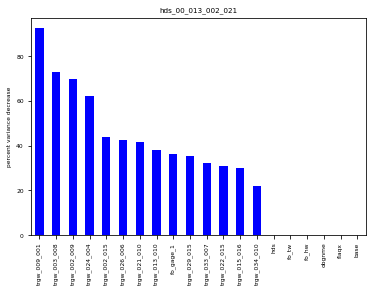

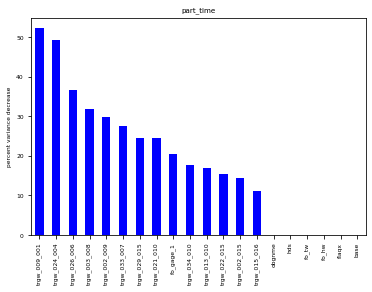

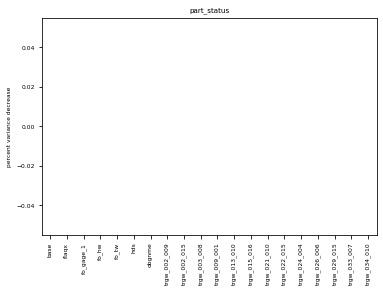

In [35]:
dw_ad = sc.get_added_obs_group_importance()
base = dw_ad.loc["base",:]
dw_ad = 100 * (base - dw_ad) / base
for forecast in dw_ad.columns:
    fore_df_ad = dw_ad.loc[:,forecast].copy()
    fore_df_ad.sort_values(inplace=True, ascending=False)
    ax = fore_df_ad.iloc[:20].plot(kind="bar",color="b")
    ax.set_title(forecast)
    ax.set_ylabel("percent variance decrease")
    plt.show()

Do these two approaches give the same answer? They shouldn't.. Why? Let's discuss..

### what is the worth of ${\it potential}$ observations? what data should we collect?

Recall we are "carrying" cell-by-cell heads, reach-based sfr flows, etc..

In [36]:
obs = sc.pst.observation_data
potential_obs = obs.loc[obs.obsnme.apply(lambda x: x.startswith("hds_02") and x.endswith("{0:03d}".format(m.nper-1))),"obsnme"].tolist()
nz_obs = set(pst.nnz_obs_names)
potential_obs = [o for o in potential_obs if o not in nz_obs]  
len(potential_obs)

705

We can therefore repeat above analysis for the observations that currently have zero weight by turning those observations "on".

#### Beware: calculating the Schur complement for all potential observation types and locations could take some time!! So we will sample to speed things up. You may need to further reduce the number of potential obs - you can do this by adding [0::2] to take every second element for example.

In [37]:
from datetime import datetime
start = datetime.now()
df_worth_new = sc.get_added_obs_importance(obslist_dict=potential_obs, base_obslist=sc.pst.nnz_obs_names, reset_zero_weight=True)
print("took:",datetime.now() - start)

took: 0:04:34.449724


In [38]:
df_worth_new.head()

,fa_hw_20171001,fa_tw_20171001,hds_00_013_002_021,part_time,part_status
base,17890.018498,14650.290571,0.016193,7014.140502,0.0
hds_02_000_000_024,17890.000389,14650.055695,0.016192,7013.311475,0.0
hds_02_000_001_024,17890.000983,14650.109220,0.016192,7013.253941,0.0
hds_02_000_002_024,17890.004764,14650.149393,0.016192,7013.167891,0.0
hds_02_000_003_024,17890.007082,14650.183456,0.016192,7013.101758,0.0


### nice! now let's process a little bit and make some plots of (potential) data worth

In [39]:
def worth_plot_prep(df):
    # some processing
    df_new_base = df.loc["base",:].copy()  # "base" row
    df_new_imax = df.apply(lambda x: df_new_base - x, axis=1).idxmax()  # obs with largest unc red for each pred
    df_new_worth = 100.0 * (df.apply(lambda x: df_new_base - x, axis=1) / df_new_base)  # normalizing like above
    
    # plot prep
    df_new_worth_plot = df_new_worth[df_new_worth.index != 'base'].copy()
    df_new_worth_plot.loc[:,'names'] = df_new_worth_plot.index
    names = df_new_worth_plot.names
    df_new_worth_plot.loc[:,"i"] = names.apply(lambda x: int(x[8:10]))
    df_new_worth_plot.loc[:,"j"] = names.apply(lambda x: int(x[11:14]))
    df_new_worth_plot.loc[:,'kper'] = names.apply(lambda x: int(x[-3:]))
    #df_new_worth_plot.head()
    
    return df_new_worth_plot, df_new_imax

In [40]:
df_worth_new_plot, df_worth_new_imax = worth_plot_prep(df_worth_new)

In [41]:
df_worth_new_plot.head()

,fa_hw_20171001,fa_tw_20171001,hds_00_013_002_021,part_time,part_status,names,i,j,kper
hds_02_000_000_024,0.000101,0.001603,0.008043,0.011819,NaN,hds_02_000_000_024,0,0,24
hds_02_000_001_024,0.000098,0.001238,0.008868,0.012640,NaN,hds_02_000_001_024,0,1,24
hds_02_000_002_024,0.000077,0.000964,0.010203,0.013866,NaN,hds_02_000_002_024,0,2,24
hds_02_000_003_024,0.000064,0.000731,0.011422,0.014809,NaN,hds_02_000_003_024,0,3,24
hds_02_000_004_024,0.000044,0.000613,0.012535,0.015406,NaN,hds_02_000_004_024,0,4,24


In [42]:
df_worth_new_imax  # which obs causes largest unc var reduction?

fa_hw_20171001        hds_02_009_016_024
fa_tw_20171001        hds_02_009_016_024
hds_00_013_002_021    hds_02_016_002_024
part_time             hds_02_015_003_024
part_status                         base
dtype: object

In [43]:
df_worth_new_plot.drop(axis=1,labels=["part_status"],inplace=True) # drop "part_status"
df_worth_new_plot.head()

,fa_hw_20171001,fa_tw_20171001,hds_00_013_002_021,part_time,names,i,j,kper
hds_02_000_000_024,0.000101,0.001603,0.008043,0.011819,hds_02_000_000_024,0,0,24
hds_02_000_001_024,0.000098,0.001238,0.008868,0.012640,hds_02_000_001_024,0,1,24
hds_02_000_002_024,0.000077,0.000964,0.010203,0.013866,hds_02_000_002_024,0,2,24
hds_02_000_003_024,0.000064,0.000731,0.011422,0.014809,hds_02_000_003_024,0,3,24
hds_02_000_004_024,0.000044,0.000613,0.012535,0.015406,hds_02_000_004_024,0,4,24


### plotting

In [44]:
def plot_added_importance(df_worth_plot, ml, forecast_name=None, 
                          newlox=None,):

    vmax = df_worth_plot[forecast_name].max()
    
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    if newlox:
        currx = []
        curry = []
        for i,clox in enumerate(newlox):
            crow = int(clox[8:10])
            ccol = int(clox[11:14])
            currx.append(ml.sr.xcentergrid[crow,ccol])
            curry.append(ml.sr.ycentergrid[crow,ccol])

    sp = ml.nper - 1
    unc_array = np.zeros_like(ml.upw.hk[0].array) - 1
    df_worth_csp = df_worth_plot.groupby('kper').get_group(sp)
    for i,j,unc in zip(df_worth_csp.i,df_worth_csp.j,
                       df_worth_csp[forecast_name]):
        unc_array[i,j] = unc 
    unc_array[unc_array == -1] = np.NaN
    cb = ax.imshow(unc_array,interpolation="nearest",
                   alpha=0.5,extent=ml.sr.get_extent(), 
                   vmin=0, vmax=vmax)
    
    plt.colorbar(cb,label="percent uncertainty reduction")

    # plot sfr
    sfr_data = ml.sfr.stress_period_data[0]
    sfr_x = ml.sr.xcentergrid[sfr_data["i"],sfr_data["j"]]
    sfr_y = ml.sr.ycentergrid[sfr_data["i"],sfr_data["j"]]
    for (x,y) in zip(sfr_x,sfr_y):
        ax.scatter([x],[y],marker="s",color="g",s=26)

    # plot the pumping wells
    wel_data = ml.wel.stress_period_data[0]
    wel_x = ml.sr.xcentergrid[wel_data["i"],wel_data["j"]]
    wel_y = ml.sr.ycentergrid[wel_data["i"],wel_data["j"]]
    for w,(x,y) in enumerate(zip(wel_x,wel_y)):
        ax.scatter([x],[y],marker="v",color="m",s=10)

    if newlox:
        for nl,(cx,cy,cobs) in enumerate(zip(currx, curry, newlox)):
            #csp = int(cobs[-1])
            #if csp == sp:
            ax.plot(cx, cy, 'rd', mfc=None, ms=10, alpha=0.8)
            ax.text(cx-50,cy-50, nl, size=10)

    # plot the location of the forecast if possible
    if forecast_name.startswith('hds'):
        i = int(forecast_name[8:10])
        j = int(forecast_name[11:14])
        forecast_x = ml.sr.xcentergrid[i,j]
        forecast_y = ml.sr.ycentergrid[i,j]
        ax.scatter(forecast_x, forecast_y, marker='o', s=600, alpha=0.5)

    ax.set_title("worth for {0}\n at kper {1}".format(forecast_name,sp), fontsize=13)
    plt.tight_layout()
    return fig

In [45]:
sc.pst.forecast_names

['fa_hw_20171001',
 'fa_tw_20171001',
 'hds_00_013_002_021',
 'part_time',
 'part_status']

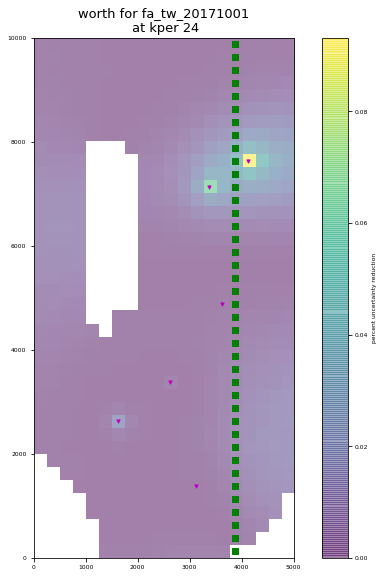

In [46]:
fig = plot_added_importance(df_worth_plot=df_worth_new_plot, ml=m,forecast_name="fa_tw_20171001")

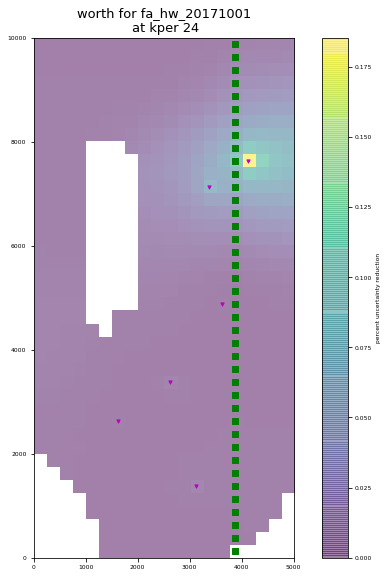

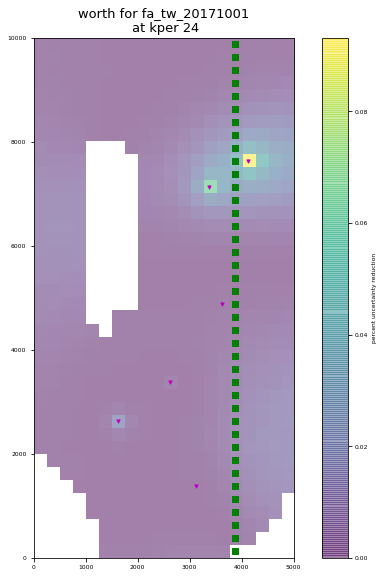

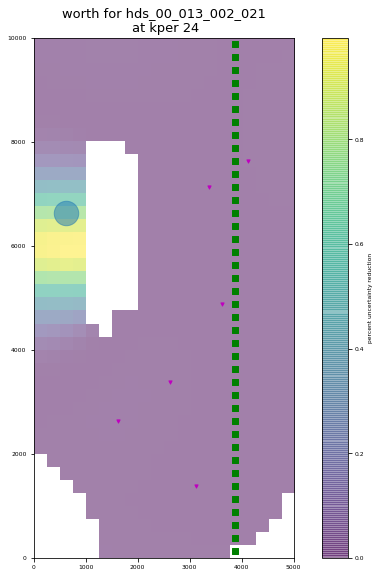

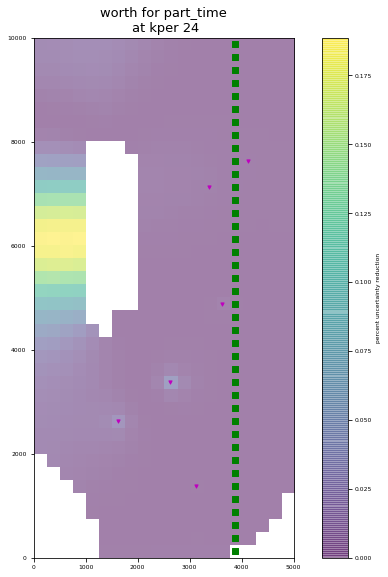

In [47]:
for i in [x for x in forecasts if "part_status" not in x]:
    fig = plot_added_importance(df_worth_plot=df_worth_new_plot, ml=m, 
                                forecast_name=i)
    #fig.savefig('add_worth_{}.pdf'.format(i))

## the "next best" observation

This is what we would ultimately like to know... Takes into account what we already know through incrementally making additional observations. For example, consider making an observation in the middle of the zone of highest worth. Where should we subsequently collect data? 

Let's just use the same potential observation list for now (the head in every top-layer cell) and evaluate which ones to collect, if we only had the budget for 5, in the context of the particle travel time prediction.

In [48]:
obs.obgnme.unique()

array(['flaqx', 'obgnme', 'fo_gage_1', 'fo_hw', 'fo_tw', 'hds',
       'trgw_002_015', 'trgw_002_009', 'trgw_003_008', 'trgw_009_001',
       'trgw_013_010', 'trgw_015_016', 'trgw_021_010', 'trgw_022_015',
       'trgw_024_004', 'trgw_026_006', 'trgw_029_015', 'trgw_033_007',
       'trgw_034_010'], dtype=object)

In [49]:
new_obs = obs.loc[obs.obsnme.apply(lambda x: x.startswith("hds_00") and x.endswith("{0:03d}".format(m.nper-1))),"obsnme"]
new_obs = new_obs.tolist()
new_obs

['hds_00_000_000_024',
 'hds_00_000_001_024',
 'hds_00_000_002_024',
 'hds_00_000_003_024',
 'hds_00_000_004_024',
 'hds_00_000_005_024',
 'hds_00_000_006_024',
 'hds_00_000_007_024',
 'hds_00_000_008_024',
 'hds_00_000_009_024',
 'hds_00_000_010_024',
 'hds_00_000_011_024',
 'hds_00_000_012_024',
 'hds_00_000_013_024',
 'hds_00_000_014_024',
 'hds_00_000_015_024',
 'hds_00_000_016_024',
 'hds_00_000_017_024',
 'hds_00_000_018_024',
 'hds_00_000_019_024',
 'hds_00_001_000_024',
 'hds_00_001_001_024',
 'hds_00_001_002_024',
 'hds_00_001_003_024',
 'hds_00_001_004_024',
 'hds_00_001_005_024',
 'hds_00_001_006_024',
 'hds_00_001_007_024',
 'hds_00_001_008_024',
 'hds_00_001_009_024',
 'hds_00_001_010_024',
 'hds_00_001_011_024',
 'hds_00_001_012_024',
 'hds_00_001_013_024',
 'hds_00_001_014_024',
 'hds_00_001_015_024',
 'hds_00_001_016_024',
 'hds_00_001_017_024',
 'hds_00_001_018_024',
 'hds_00_001_019_024',
 'hds_00_002_000_024',
 'hds_00_002_001_024',
 'hds_00_002_002_024',
 'hds_00_00

In [50]:
pst.forecast_names

['fa_hw_20171001',
 'fa_tw_20171001',
 'hds_00_013_002_021',
 'part_time',
 'part_status']

In [51]:
start = datetime.now()
next_most_df = sc.next_most_important_added_obs(forecast='fa_tw_20171001',niter=5,obslist_dict=dict(zip(new_obs,new_obs)),
                                                base_obslist=sc.pst.nnz_obs_names,reset_zero_weight=True)
print("took:",datetime.now() - start)

took: 0:21:51.708574


In [52]:
next_most_df

,best_obs,fa_tw_20171001_variance,unc_reduce_iter_base,unc_reduce_initial_base
hds_00_009_016_024,hds_00_009_016_024,14637.271594,0.088865,0.088865
hds_00_011_013_024,hds_00_011_013_024,14628.513596,0.059834,0.148645
hds_00_009_017_024,hds_00_009_017_024,14622.007505,0.044475,0.193055
hds_00_010_016_024,hds_00_010_016_024,14615.883479,0.041882,0.234856
hds_00_008_016_024,hds_00_008_016_024,14610.327197,0.038015,0.272782


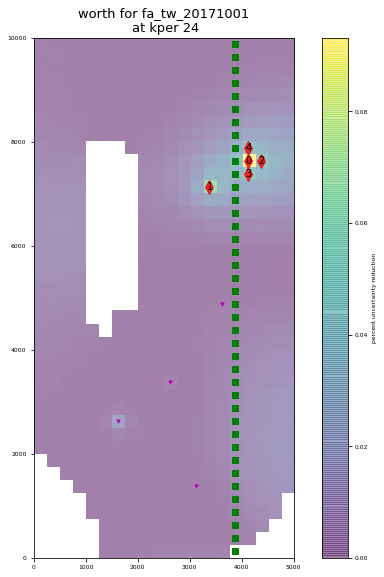

In [53]:
fig = plot_added_importance(df_worth_new_plot, m, 'fa_tw_20171001', 
                            newlox=next_most_df.best_obs.tolist())

### Note: an important assumption underpinning the above is that the model is able to fit observations to a level that is commensurate with measurement noise... Are we comfortable with this assumption? We will discuss this more in `pestpp-glm_part2.ipynb`

In [54]:
# recall...
pst.observation_data.loc[pst.nnz_obs_names,:]

,obsnme,obsval,weight,obgnme,extra
obsnme,,,,,
fo_gage_1_20160101,fo_gage_1_20160101,7811.571739,0.0015,fo_gage_1,NaN
fo_gage_1_20160201,fo_gage_1_20160201,8486.782129,0.0015,fo_gage_1,NaN
fo_gage_1_20160301,fo_gage_1_20160301,9701.533827,0.0015,fo_gage_1,NaN
fo_gage_1_20160401,fo_gage_1_20160401,9391.429930,0.0015,fo_gage_1,NaN
fo_gage_1_20160501,fo_gage_1_20160501,7907.122907,0.0015,fo_gage_1,NaN
...,...,...,...,...,...
trgw_034_010_20170901,trgw_034_010_20170901,33.931110,3.0000,trgw_034_010,NaN
trgw_034_010_20171001,trgw_034_010_20171001,33.955884,3.0000,trgw_034_010,NaN
trgw_034_010_20171101,trgw_034_010_20171101,33.985823,3.0000,trgw_034_010,NaN


### an "extra" if we have time: parameter identifiability

In [55]:
la = pyemu.ErrVar(jco=jco)

In [56]:
s = la.qhalfx.s  # singular spectrum
s.x[:10]

array([[43.69132712],
       [30.21721185],
       [25.80378018],
       [23.17796605],
       [15.67055625],
       [11.97891618],
       [11.83315608],
       [10.41029437],
       [ 7.96296402],
       [ 7.22180919]])

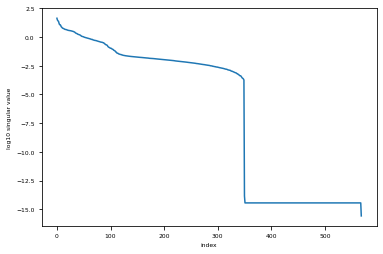

In [57]:
figure = plt.figure()
ax = plt.subplot(111)
ax.plot(np.log10(s.x))
ax.set_ylabel("log10 singular value")
ax.set_xlabel("index")
#ax.set_xlim(0,100)
plt.show()

As expected, singluar spectrum decays rapidly.

In [58]:
truncation_thresh = 5e-5
n_signif_singvals = ((s.x / s[0].x) > truncation_thresh).sum()
n_signif_singvals

304

In [59]:
print("This means that, on the basis of the {0} (non-zero) weighted observations, \
there are {1} unique pieces of information in the calibration dataset.  \
Recall the inverse problem we are trying to solve involves the estimation of {2} parameters using this information only...".\
      format(la.pst.nnz_obs, n_signif_singvals, pst.npar_adj))

This means that, on the basis of the 350 (non-zero) weighted observations, there are 304 unique pieces of information in the calibration dataset.  Recall the inverse problem we are trying to solve involves the estimation of 569 parameters using this information only...


Now let's compute the identifiability of actual model parameters based on these singular vectors. Identifiability ranges from 0 (not identified by the data) to 1 (full identified by the data).

In [60]:
ident_df = la.get_identifiability_dataframe(4)  # sing val trunc defaults to pst.nnz_obs

<AxesSubplot:>

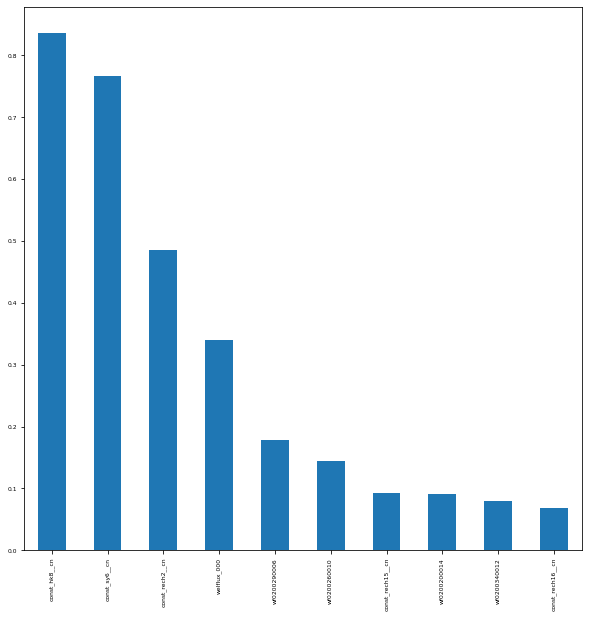

In [61]:
ident_df.sort_values(by="ident",ascending=False).iloc[0:10].loc[:,"ident"].plot(kind="bar",figsize=(10,10))

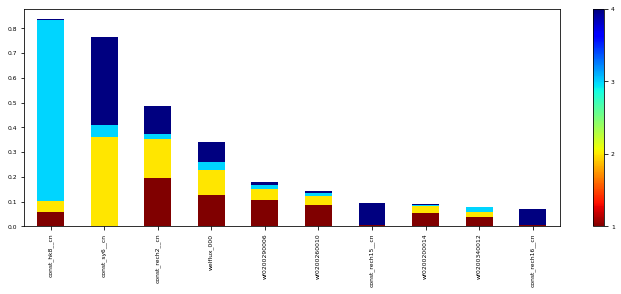

In [62]:
id = pyemu.plot_utils.plot_id_bar(ident_df.sort_values(by="ident",ascending=False).iloc[0:10], figsize=(12,4))

Note similarity with some of the earlier parameter contribution to forecast uncertainty results

In [63]:
css = la.get_par_css_dataframe()
css.head()

,pest_css,hill_css
const_hk6__cn,0.000751,0.0
const_hk7__cn,0.000097,0.0
const_hk8__cn,0.072513,0.0
const_prsity6__cn,0.000000,0.0
const_prsity7__cn,0.000000,0.0


In [64]:
css = css.sort_values(by="pest_css",ascending=False)
css = css.loc[css.pest_css==0.0,:]
len([p for p in css.index if "sy" in p])

66

In [65]:
par = pst.parameter_data.loc[pst.adj_par_names]
par.loc[par.parnme.apply(lambda x: "sy" in x),:].shape

(99, 11)